Starting Gibbs Sampler...


100%|██████████| 200/200 [00:57<00:00,  3.46it/s]


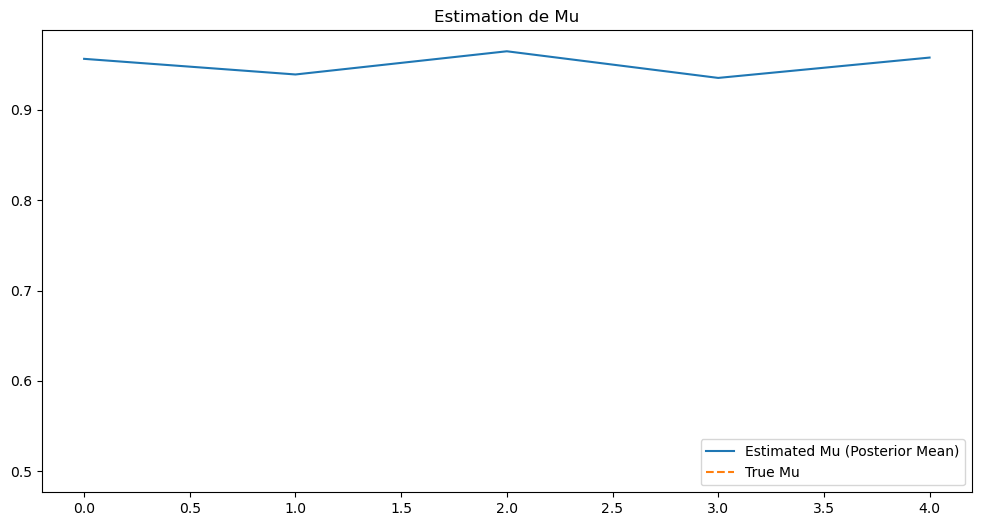

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gibbs import GibbsFactorCopula

# --- 1. Define the simulation function (from Cell 1 of the notebook) ---
def simulate_heterogeneous_model(n_obs, n_assets, n_factors, 
                                 mu, phi, sigma_eta, nu, 
                                 seed=2):
    if seed is not None:
        np.random.seed(seed)
        
    def format_param(param, name):
        p = np.array(param)
        if p.ndim == 0:
            return np.full((n_assets, n_factors), p)
        elif p.ndim == 1:
            if len(p) != n_assets:
                raise ValueError(f"La taille de {name} ({len(p)}) ne matche pas n_assets ({n_assets})")
            return p[:, np.newaxis]
        else:
            return p

    mu_mat = format_param(mu, 'mu')
    phi_mat = format_param(phi, 'phi')
    sig_mat = format_param(sigma_eta, 'sigma_eta')
    
    f_t = np.random.normal(0, 1, size=(n_obs, n_factors))
    eps_t = np.random.normal(0, 1, size=(n_obs, n_assets))
    w = np.random.chisquare(df=nu, size=n_obs)
    zeta_t = nu / np.maximum(w, 1e-10)
    
    raw_eta = np.random.normal(0, 1, size=(n_obs, n_assets, n_factors))
    eta_t = raw_eta * sig_mat[np.newaxis, :, :] 

    lambdas = np.zeros((n_obs, n_assets, n_factors))
    std_stat = sig_mat / np.sqrt(1 - phi_mat**2)
    lambdas[0] = np.random.normal(mu_mat, std_stat)
    
    for t in range(1, n_obs):
        lambdas[t] = mu_mat + phi_mat * (lambdas[t-1] - mu_mat) + eta_t[t]
        
    # Adjustment for the Copula Model (scaling by sqrt(1 + sum lambda^2))
    # to match the likelihood in gibbs.py
    # x = sqrt(zeta) * (lambda * f + eps) / sqrt(1 + sum lambda^2)
    
    x = np.zeros((n_obs, n_assets))
    for t in range(n_obs):
        lam_t = lambdas[t] # (N, P)
        z_t = f_t[t]       # (P,)
        zetat = zeta_t[t]  # (1,)
        
        factor_comp = np.dot(lam_t, z_t) # (N,)
        lam_sq = np.sum(lam_t**2, axis=1) # (N,)
        scaling = np.sqrt(1.0 + lam_sq)
        
        zeta_sqrt = np.sqrt(zetat)
        mean_obs = zeta_sqrt * (factor_comp / scaling)
        scale_obs = zeta_sqrt * (1.0 / scaling)
        
        x[t] = np.random.normal(loc=mean_obs, scale=scale_obs)
    
    return x, lambdas, zeta_t

# --- 2. Run Simulation ---
N = 5
P = 1
T = 300
phi_per_asset = 0.50 # np.array([0.99, 0.99, 0.99, 0.80, 0.80])
sigma_per_asset = 0.05 #np.array([0.1, 0.12, 0.15, 0.08, 0.05])
mu_true = - 0.5
nu_true = 5

x, true_lambdas, true_zeta = simulate_heterogeneous_model(
    n_obs=T, n_assets=N, n_factors=P,
    mu=mu_true,
    phi=phi_per_asset,
    sigma_eta=sigma_per_asset,
    nu=nu_true,
    seed=2
)

# --- 3. Run Gibbs Sampler ---
gibbs = GibbsFactorCopula(x, n_factors=P, nu=5)
n_burnin = 50 # Low for quick execution in this context, but better for demo
n_iter = 200

post_lambda_sum = np.zeros_like(true_lambdas)
post_mu_sum = np.zeros_like(gibbs.theta['mu'])
post_phi_sum = np.zeros_like(gibbs.theta['phi'])

print("Starting Gibbs Sampler...")
for it in tqdm(range(n_iter)):
    gibbs.update_zeta()
    #gibbs.update_nu(rw_step=0.5)
    gibbs.update_z()
    gibbs.update_lambda_pg() # Using non-parallel for stability in this env
    gibbs.update_sigma()
    gibbs.update_mu_phi()
    
    if it >= n_burnin:
        post_lambda_sum += gibbs.lambdas
        post_mu_sum += gibbs.theta['mu']
        post_phi_sum += gibbs.theta['phi']
        #print(gibbs.theta['mu'])

post_lambda_mean = post_lambda_sum / (n_iter - n_burnin)
post_mu_mean = post_mu_sum / (n_iter - n_burnin)
post_phi_mean = post_phi_sum / (n_iter - n_burnin)

# --- 4. Visualization ---
plt.figure(figsize=(12, 6))
# plot des mus
plt.plot(post_phi_mean, label='Estimated Mu (Posterior Mean)')
plt.plot(phi_per_asset, label='True Mu', linestyle='--')
plt.title("Estimation de Mu")
plt.legend()

In [2]:
gibbs.theta['mu']

array([[-0.96697812],
       [ 0.01064414],
       [ 0.65772741],
       [ 0.29133826],
       [ 0.41751962]])

In [3]:
post_mu_mean

array([[0.06527457],
       [0.32890751],
       [0.38960931],
       [0.24031776],
       [0.59290799]])

In [4]:
plt.figure(figsize=(10, 6))
asset_to_plot = 0 # Premier actif

# Moyenne a posteriori (après avoir stocké les itérations dans une liste 'samples')
post_mean_lambda = np.mean(samples_lambda, axis=0) 

plt.plot(true_lambdas[:, asset_to_plot], color='black', label='Vrai Lambda (Simulé)')
plt.plot(post_mean_lambda[:, asset_to_plot], '--', color='red', label='Estimation Gibbs')

plt.title(f"Comparaison : Valeur réelle vs Estimation (Actif {asset_to_plot+1})")
plt.xlabel("Temps (t)")
plt.ylabel("Chargement Lambda")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

NameError: name 'samples_lambda' is not defined

<Figure size 1000x600 with 0 Axes>

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
C:\Users\vautr\AppData\Local\Temp\ipykernel_2452\4236493100.py:49: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(range(N), [mu_vrai]*N, 'ko', markersize=10, label='Vrai $\mu$')
C:\Users\vautr\AppData\Local\Temp\ipykernel_2452\4236493100.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(range(N), mu_est, 'rx', markersize=10, markeredgewidth=2, label='Estimé $\mu$')


Exécution de l'échantillonneur de Gibbs...


100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


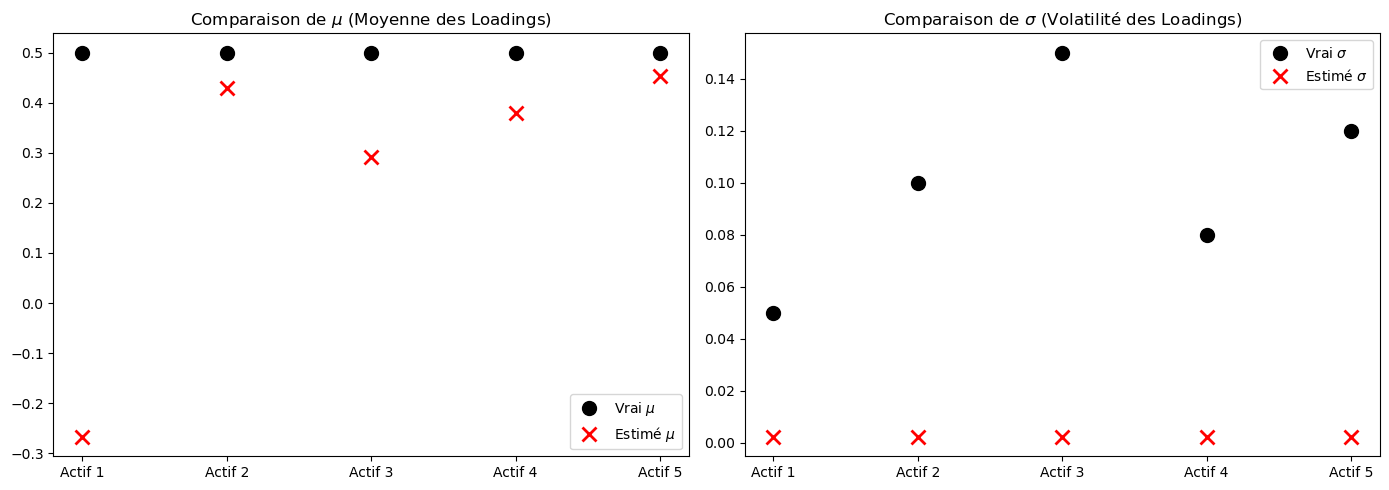

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gibbs import GibbsFactorCopula # Importe ta classe

# 1. Génération des données avec TA fonction de simulation
N = 5
P = 1
T = 200
mu_vrai = 0.5
phi_vrai = np.array([0.98, 0.95, 0.90, 0.85, 0.80])
sigma_vrai = np.array([0.05, 0.10, 0.15, 0.08, 0.12])

x, true_L, true_Zeta = simulate_heterogeneous_model(
    n_obs=T, n_assets=N, n_factors=P,
    mu=mu_vrai, phi=phi_vrai, sigma_eta=sigma_vrai, nu=5.0, seed=42
)

# 2. Initialisation et exécution de TON Gibbs
gibbs = GibbsFactorCopula(x, n_factors=P, nu=10)
n_iter = 1000
n_burnin = 200

# Stockage pour les moyennes
post_mu = []
post_sigma = []

print("Exécution de l'échantillonneur de Gibbs...")
for it in tqdm(range(n_iter)):
    gibbs.update_zeta()
    gibbs.update_nu()
    gibbs.update_z()
    gibbs.update_lambda_pg() 
    gibbs.update_sigma()
    gibbs.update_mu_phi()
    
    if it >= n_burnin:
        post_mu.append(gibbs.theta['mu'].copy())
        post_sigma.append(gibbs.theta['sigma'].copy())

# Calcul des moyennes a posteriori
mu_est = np.mean(post_mu, axis=0).flatten()
sigma_est = np.mean(post_sigma, axis=0).flatten()

# 3. Visualisation des paramètres statiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot pour MU
ax1.plot(range(N), [mu_vrai]*N, 'ko', markersize=10, label='Vrai $\mu$')
ax1.plot(range(N), mu_est, 'rx', markersize=10, markeredgewidth=2, label='Estimé $\mu$')
ax1.set_title("Comparaison de $\mu$ (Moyenne des Loadings)")
ax1.set_xticks(range(N))
ax1.set_xticklabels([f"Actif {i+1}" for i in range(N)])
ax1.legend()

# Plot pour SIGMA
ax2.plot(range(N), sigma_vrai, 'ko', markersize=10, label='Vrai $\sigma$')
ax2.plot(range(N), sigma_est, 'rx', markersize=10, markeredgewidth=2, label='Estimé $\sigma$')
ax2.set_title("Comparaison de $\sigma$ (Volatilité des Loadings)")
ax2.set_xticks(range(N))
ax2.set_xticklabels([f"Actif {i+1}" for i in range(N)])
ax2.legend()

plt.tight_layout()
plt.show()